

## 航空宇宙情報システム学第二

<h1><center> 第3回 SciPy, Matplitlib, Pandas </center> </h1>

<center>

2023年4月25日

担当教員: 矢入健久

e-mail: yairi@g.ecc.u-tokyo.ac.jp
</center>




# はじめに

前回紹介したNumPyを使えば、行列ベクトル演算を中心に様々な数値計算を効率的に行うことができますが、PythonにはNumPyの機能を拡張したり補完するライブラリ（モジュール）が多数存在します。そのような中から、今日は、
1. **SciPy** : NumPyをベースとして、科学技術計算を行うのに便利な機能を提供するライブラリ。
1. **Matplotlib** : データのプロットなど、グラフィクス・可視化の機能を提供するライブラリ。
1. **Pandas** : データを効率的に管理、操作、解析するためのライブラリ。

の3つをごく手短に紹介していきたいと思います。

# SciPy

SciPy には、科学技術目的の計算を行う上で、NumPyを拡張・補完する様々な機能が含まれているのですが、それらを全部ここで紹介することはできません（そもそも、NumPyも全てを紹介できていない。。）。
今回は、多くの機能の中からごく一部、
- 発展的な線形代数的計算
- 常微分方程式の数値解法

を手短に説明します。また、後日、SciPyの最適化手法や統計的手法についても取り上げる予定です。



## 行列指数関数

先学期の情報システム学第一で以下のような線形の常微分方程式の例題を扱いました。

---
**[例題] 減衰振動**

減衰振動の挙動を表す微分方程式:
$$
\ddot{x} + 2 \gamma \dot{x} + \omega_0^2 x = 0 \tag{Eq.3-1}
$$
の挙動を調べよ。各パラメータの値は、$\gamma=0.3$, $\omega_0^2 = 1.0$、初期状態は、$x(0)=1.0$, $\dot{x}(0)=1.0$ とする。

---

この問題は、状態ベクトル$\boldsymbol{x}=[x,\dot{x}]^\top$ と行列$\boldsymbol{A}$を、
$$
\boldsymbol{A} = \left[
  \begin{matrix}
  0 & 1\\
  -\omega_0^2 & -2 \gamma
  \end{matrix}
  \right] \tag{Eq.3-2}
$$
のように定義すれば、
$$
\dot{\boldsymbol{x}} = \boldsymbol{A} \boldsymbol{x} \tag{Eq.3-3}
$$
と表すことができます。そしてその解は、<font color="red"> 行列指数関数 </font>を用いて、
$$
\boldsymbol{x}(t) = e^{t\boldsymbol{A}}  \boldsymbol{x}(0)
\tag{Eq.3-4}
$$
のように求まります。

さらに、時間軸を時間幅$\Delta t$で離散化し、離散時刻インデクス$k$における状態ベクトルを、
$$
\boldsymbol{x}_k = \boldsymbol{x}(k\cdot \Delta t)
$$
と書くことにすれば、
$$
\begin{align}
\boldsymbol{x}_{k+1} &= \boldsymbol{x}((k+1)\cdot \Delta t)
= e^{(k+1)\Delta t \boldsymbol{A}}  \boldsymbol{x}(0)
= e^{\Delta t \boldsymbol{A}} \cdot e^{k\Delta t \boldsymbol{A}}  \boldsymbol{x}(0) \\
&= e^{\Delta t \boldsymbol{A}} \cdot \boldsymbol{x}_{k}
\end{align} \tag{Eq.3-5}
$$
という漸化式（差分方程式）が得られます。

ここで、右辺に現れる$e^{\Delta t \boldsymbol{A}}$は、**行列指数関数** と呼ばれるものです。もう少し細かく見ると、
- $e$は、おなじみ、自然対数の底、オイラー数、ネイピア数と呼ばれるものです。つまり、スカラーです。
- $\Delta t$は連続時刻を離散化するときの時間の刻み幅であり、これもスカラーです。
- $\boldsymbol{A}$は、(この例題の場合は$2\times 2$の)正方行列です。従って、スカラー$\Delta t$を掛けた $\Delta t\boldsymbol{A}$も正方行列です。

正方行列$\boldsymbol{X}$に対して、指数関数行列 $e^\boldsymbol{X}$は、行列の無限級数和
$$
e^\boldsymbol{X} \equiv \sum_{n=0}^\infty \frac{1}{n!} \boldsymbol{X}^n
\tag{Eq.3-6}
$$
で定義されます。通常の指数関数$e^x$のマクローリン展開
$$
e^x = \sum_{n=0}^\infty \frac{1}{n!} x^n
\tag{Eq.3-7}
$$
との類似していることが分かります。ただし、行列$\boldsymbol{X}$の$0$乗は、1ではなく、単位行列です。
$$
\boldsymbol{X}^0 = \boldsymbol{I} \tag{Eq.3-8}
$$

上記の定義に従って行列指数関数を求めることもできますが、毎回それをやるのは面倒です。行列指数関数を求める関数はNumPy自体にはありませんが、SciPyには用意されています。`linalg`サブモジュールに含まれる`expm()`関数です。
* (注) numpyにも`linalg`サブモジュールがありました（というか、numpyの`linalg`サブモジュールの方が有名）。紛らわしいので注意しましょう。

早速、これを使って、$e^{\Delta t \boldsymbol{A}}$を求めてみます。ただし、<font color="blue">今回は、時間刻み幅$\Delta t$を0.1とします。</font>

In [ ]:
import numpy as np
import scipy.linalg as spla
# 行列A
A = np.array([[0.0, 1.0],[-1.0, -0.6]])
print('A=\n',A)
# 行列　dt A
dtA = 0.1 * A
print('dt A=\n',dtA)
# dt Aの指数関数行列
expdtA = spla.expm(dtA)
print('exp(dt A)=\n',expdtA)


A=
 [[ 0.   1. ]
 [-1.  -0.6]]
dt A=
 [[ 0.    0.1 ]
 [-0.1  -0.06]]
exp(dt A)=
 [[ 0.99510258  0.09689744]
 [-0.09689744  0.93696412]]


この例題の場合、
$$
e^{\Delta t \boldsymbol{A}} = \left[
\begin{matrix}
0.99510258 & 0.09689744 \\
-0.09689744 & 0.93696412
\end{matrix}
  \right]\tag{Eq.3-9}
$$
であることが分かります。



**(例題)** 上で求めた指数関数行列$e^{\Delta t \boldsymbol{A}}$ と、漸化式
$\boldsymbol{x}_{k+1} = e^{\Delta t \boldsymbol{A}} \cdot \boldsymbol{x}_{k}$、初期条件 $\boldsymbol{x}_0 = \left[1, 1 \right]^\top$を用いて、$t=0.0$(sec)から$t=10.0$(sec)まで、状態ベクトル $\boldsymbol{x}_0, \boldsymbol{x}_1, \cdots,\boldsymbol{x}_{10}$を**逐次的に**求めてください。。

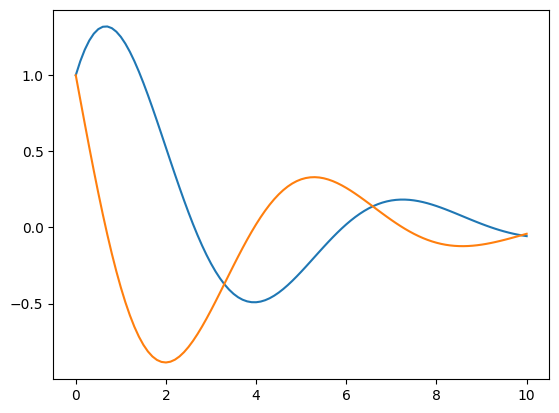

In [ ]:
# 時刻列[0.0,0.1,...,10.0]をベクトルとして用意
t = np.linspace(0.0,10.0,101)
# Xは各時刻の状態を格納するための行列。最初は時刻t=0の状態のみを含む
X = np.array([[1.0,1.0]])
for k in range(100):
  xnext = np.dot(expdtA,X[k,:])
  X = np.vstack((X,xnext))
#Matplotlibでプロット
import matplotlib.pyplot as plt
plt.plot(t,X)

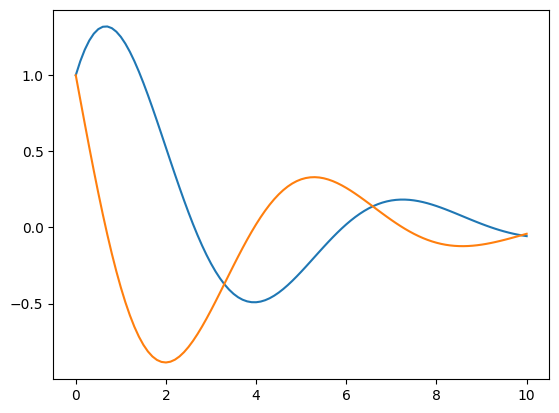

In [ ]:
# 時刻列[0.0,0.1,...,10.0]をベクトルとして用意
t = np.linspace(0.0,10.0,101)
# 各時刻の状態ベクトルを格納するためのゼロ行列を用意
X = np.zeros((101,2))
# 初期状態を設定
X[0,:] = np.array([1.0,1.0])
for k in range(100):
  X[k+1,:] = np.dot(expdtA,X[k,:])

#Matplotlibでプロット
import matplotlib.pyplot as plt
plt.plot(t,X)

**(練習)** `expm()`を使わず、級数和による行列指数関数の定義に従って、$e^{\Delta t \boldsymbol{A}}$（の近似値）を求めてください。定義上は無限級数和ですが、第何項までの和を計算すれば十分な精度になるかも確かめてみてください。

(ヒント) $\boldsymbol{C}_n=\frac{1}{n!}\boldsymbol{B}^n$ と置いたとき、$\boldsymbol{C}_0=\boldsymbol{I}$,  $\boldsymbol{C}_{n+1}=\frac{1}{n+1} \boldsymbol{B} \boldsymbol{C}_k$ となることを利用すると、$n=0,1,\cdots,N$までの級数和を逐次的に計算することができます。

## NumPyの線形代数計算を補完する関数たち

ここで取り上げた行列指数関数 `expm()`は、SciPyが提供する線形代数関連の関数のなかの単なる1例であり、他にも色々な関数が提供されています。例えば、行列指数関数、行列三角関数、などです。また、制御理論で使われるシルベスター方程式、リアプノフ方程式を解く関数なども提供されています。

## 常微分方程式(ODE)の数値解法再び

先学期の第一では、最後に、オイラー法、修正（改良）オイラー法、ルンゲ・クッタ法による、常微分方程式の数値解法アルゴリズムを作成しました。少し復習してみます。

まず、与えられた常微分方程式を、
$$
\dot{\boldsymbol{x}}=\boldsymbol{f}(t,\boldsymbol{x}) \tag{Eq.3-10}
$$
のような形式で表現し、右辺の$\boldsymbol{f}(t,\boldsymbol{x})$の部分を関数として実装しました。例えば、減衰振動の場合は、(Eq.3-2) (Eq.3-3)より、
$$
\left[ \begin{matrix} \dot{x} \\ \ddot{x} \end{matrix} \right]
= \left[
  \begin{matrix}
  0 & 1\\
  -\omega_0^2 & -2 \gamma
  \end{matrix}
  \right]
  \left[ \begin{matrix} x \\ \dot{x} \end{matrix} \right] \tag{Eq.3-11}
$$
となり、このときはまだNumPyを紹介していなかったので、<font color="red">リストをベクトルの代わりに使って</font>、次のような関数を作成しました。

```
# 減衰振動の微分方程式を標準形に直したときの右辺 f(t,x)の部分を計算する関数
# xlst, dx はリスト
def deriv_damp_osc(t,xlst):
  dx = [xlst[1], -om0sq*xlst[0] - 2*gam*xlst[1]]
  return dx
```

これを、NumPyの行列とベクトル(array)を使って書いてみると、例えばこんな感じになるかと思います。行列$\boldsymbol{A}$は関数の外で（すなわちグローバル変数として）定義されている点に注意してください。


In [ ]:
#減衰振動の微分方程式を標準形に直したときの右辺 f(t,x)の部分を計算する関数
# xvec, dx はベクトル(1次元array)
def deriv_damp_osc(t,xvec):
  dx = np.dot(A,xvec)
  return dx


行数(3行)は変わっていませんが、ずいぶんスッキリしました。これは方程式が線形なので行列・ベクトル積(`dot()`)を使えるところが大きいです。

さて、この`deriv_damp_osc()`を使って、ルンゲ・クッタ法を適用してみます。

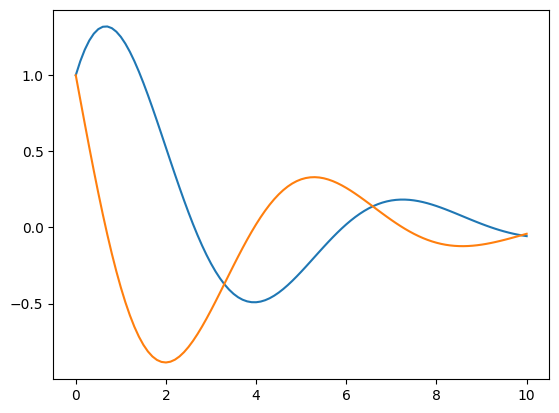

In [ ]:
# 時間刻み幅
dlt = 0.1
# 時刻列
t = np.arange(0.0,10.01,0.1)
# 時刻点数
nt = len(t)

# 各時刻の状態(位置,速度)を保存する配列(Nx2行列)
Xrk = np.zeros((nt,2))
# 初期状態
Xrk[0,:] = 1.0  # Xrk[0,0]=Xrk[0,1]=1.0
# k=1からk=nt-1まで繰り返し
for k in range(1,nt):
  K1 = deriv_damp_osc(t[k-1],Xrk[k-1,:])
  K2 = deriv_damp_osc(t[k-1],Xrk[k-1,:]+0.5*dlt*K1)
  K3 = deriv_damp_osc(t[k-1],Xrk[k-1,:]+0.5*dlt*K2)
  K4 = deriv_damp_osc(t[k-1],Xrk[k-1,:]+dlt*K3)
  Xrk[k,:] = Xrk[k-1,:] + dlt*(K1+2*K2+2*K3+K4)/6

plt.plot(t,Xrk)

ベクトル演算のおかげでかなり簡潔になりました。

## SciPyの常微分方程式ソルバー(scipy.integrate.solve_ivp())

少し脱線してしましましたが、話題をSciPyに戻します。
実は、SciPyには、ルンゲ・クッタ法などの常微分方程式を解くためのアルゴリズムが`scipy.integrate.solve_ivp()`としてあらかじめ用意されています。

[公式のマニュアル](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html#scipy.integrate.solve_ivp)を読むと、
非常に多数のオプション引数が用意されており、動作を細かく指定することができますが、最低限、`solve_ivp(fun, t_span, y0)`のように3つの引数を与えれば動きます。ここで、3つの必須の引数は、
- `fun` : 標準形の微分方程式の右辺 f(t,x)を具体的に計算する関数。
- `t_span` : 開始時刻と終端時刻の組（タプル）
- `y0` : 初期状態(ベクトル)
です。

自前のルンゲ・クッタ法では実装の容易さから、時刻の刻み幅$\Delta t$を固定にしていましたが、<font color="blue">SciPyが提供する常微分方程式ソルバーでは、近似誤差が指定値内に収まるように、時刻刻み幅を自動調整してくれます。</font>

`solve_ivp()`関数は、計算した数値解をクラスオブジェクトで返します。下のコードではそれを`sol`という変数で受け取っています。その場合、時刻列を`sol.t`、対応する各時刻の解の値の列を`sol.y`としてNumPyのarray型で得ることができます。<font color="red"> ただし、`sol.y`は、「次元$\times$時刻列の長さ」の横長の行列</font>になっています。

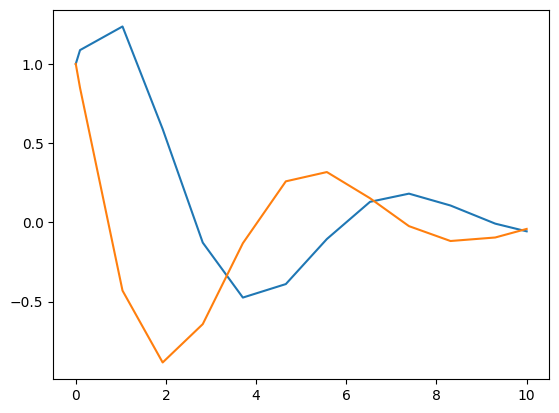

In [ ]:
from scipy.integrate import solve_ivp
# 時刻刻み幅は自動調整
sol = solve_ivp(deriv_damp_osc, (0.0,10.0), [1.0,1.0])
plt.plot(sol.t,sol.y.T) # plot関数の仕様上、sol.y を転置している

随分、カクカクして、一見正確そうに見えないですが、ちゃんと誤差が一定範囲内に収まるように時刻刻み幅が決定されています。
減衰振動のような非常に「素直な」系の場合、<font color="red">時刻列を思い切り間引いてしまう</font>ので、下の例のように、最大の時刻ステップ幅(`max_step`)を0.1に設定して見た目を良くしています。

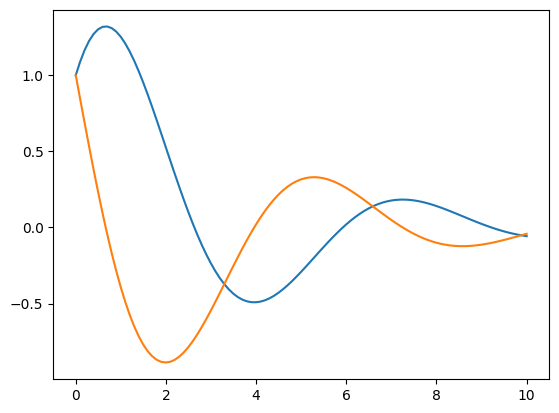

In [ ]:
# 時刻ステップの最大幅を0.1に指定
sol2 = solve_ivp(deriv_damp_osc, (0.0,10.0), [1.0,1.0],max_step=0.1)

plt.plot(sol2.t,sol2.y.T)


### ローレンツ方程式の場合

数式で解くことができる減衰振動だけでは面白くないので、非線形の常微分方程式の例として、ローレンツ方程式も、SciPyの`solve_ivp()`関数で数値的に解いてみましょう。3つの状態変数を$\boldsymbol{x}(t)=[x_0(t)$,$x_1(t)$,$x_2(t)]^\top$として、以下の連立微分方程式で表されます。
$$
\left[\begin{matrix} \dot{x}_0 \\ \dot{x}_1 \\ \dot{x}_2\end{matrix}\right]
= \left[\begin{matrix}
\sigma (x_1 - x_0) \\ x_0 (\rho - x_2)-x_1 \\
x_0 x_1 - \beta x_2 \end{matrix} \right] \tag{Eq.3-12}
$$
パラメータ $\sigma$, $\rho$, $\beta$の値はそれぞれ、
$\sigma=10$, $\rho=28$, $\beta=\frac{8}{3}$とし、
初期値は$\boldsymbol{x}(0)=[1,-1,2]^\top$とします。

この場合も、右辺を計算する関数は自分で定義しておく(下のコードでは、`deriv_lorenz(t,x)`として定義)必要がありますが、後はSciPyの`solve_ivp()`関数に任せれば勝手に数値解を求めてくれます。

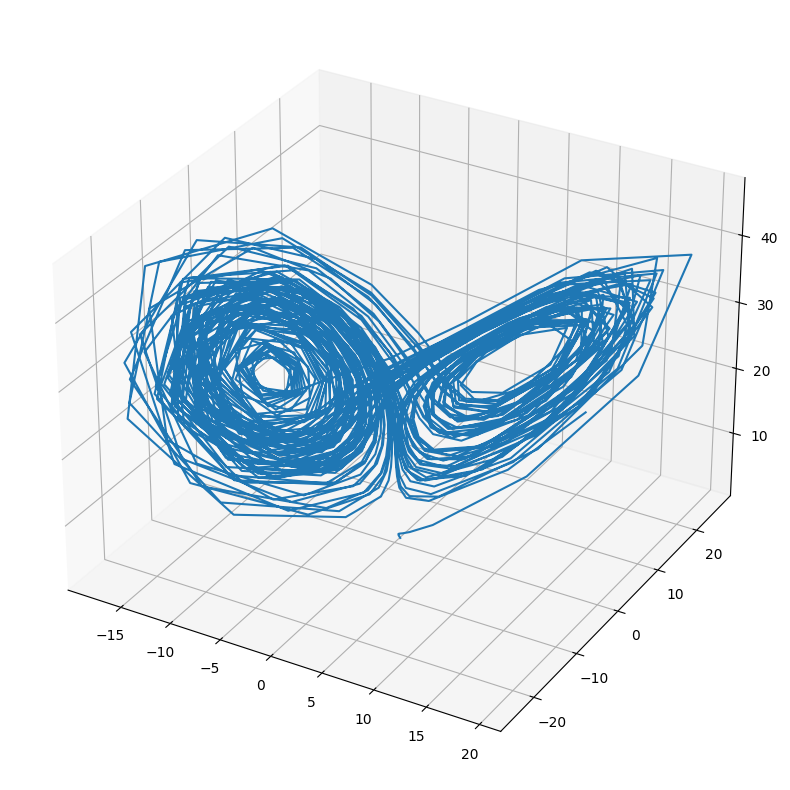

In [ ]:
# パラメータ
s = 10.0
b = 8.0/3.0
r = 28.0

# 状態ベクトルの時間微分を計算する関数
def deriv_lorenz(t,x):
    dx = s*(x[1]-x[0])
    dy = x[0]*(r-x[2])-x[1]
    dz = x[0]*x[1]-b*x[2]
    dxdydz = np.array([dx,dy,dz])
    return dxdydz

# 後はsolve_ivpに丸投げ
sol_lor = solve_ivp(deriv_lorenz, (0.0,100.0), np.array([1,-1,2]))

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
#ax = fig.gca(projection='3d')
ax.plot(sol_lor.y[0,:], sol_lor.y[1,:], sol_lor.y[2,:])



この場合も誤差を一定範囲内の抑えつつ、時刻の刻み幅をできるだけ大きくしているので、見た目はカクカクしています。実際に各ステップで刻み幅がどのように遷移しているかを見てみます。`so_lor.t`として得られている時刻列を`np.diff()`によって前後差分を取れば、時刻刻み幅の数列が得られますので、これをプロットしてみます。

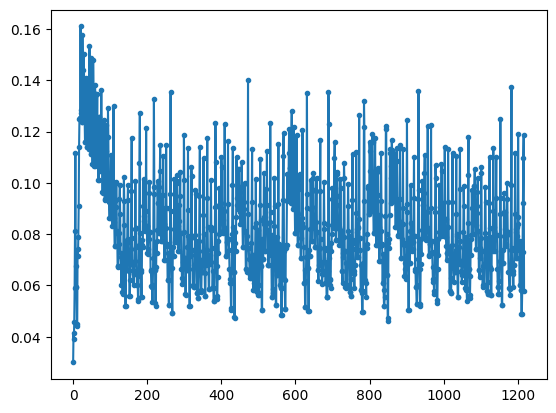

In [ ]:
plt.plot(np.diff(sol_lor.t),'.-')

刻み幅が0.04から0.16くらいの範囲で遷移していることが分かります。強制的に最大の刻み幅を0.02にしてみると、かなり滑らかな図が得られます。

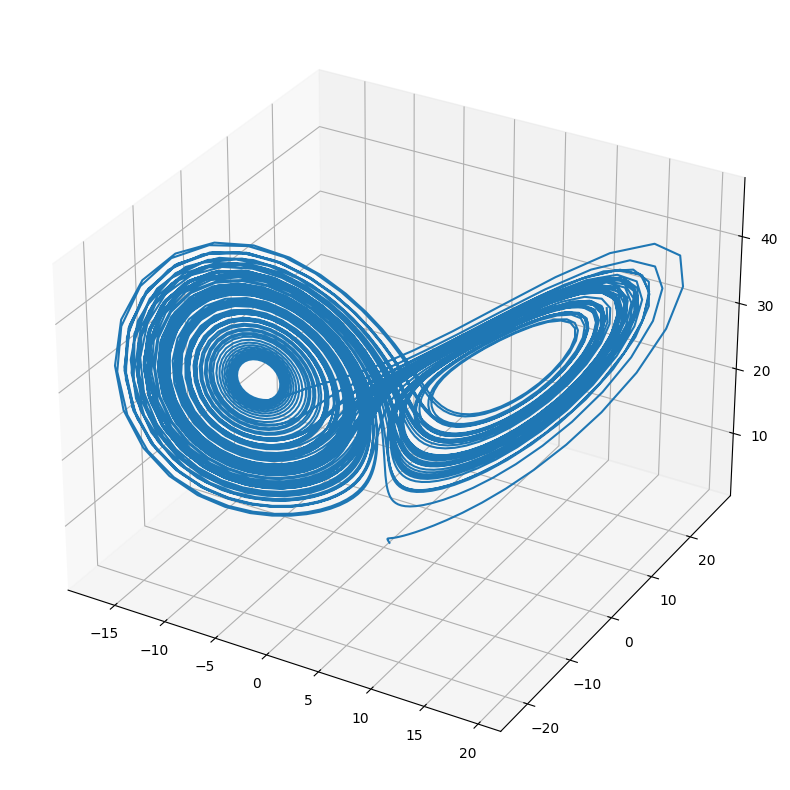

In [ ]:
# max_step=0.05
sol_lor = solve_ivp(deriv_lorenz, (0.0,100.0), [1,-1,2],max_step=0.02)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
#ax = fig.gca(projection='3d')
ax.plot(sol_lor.y[0,:], sol_lor.y[1,:], sol_lor.y[2,:])


このように、SciPyが提供する常微分方程式数値ソルバーは、比較的簡単に使うことができる上に、最適な刻み幅を適応的に決めてくれたり、さらにきめ細かくオプションを設定することができるので大変便利です。

# Matplotlib

既に何度も使っているので、今さらという感じがしなくもありませんが、Pythonでグラフ（チャート）などを描く際によく使われているMatplotlibを簡単に紹介します。これも非常に多数の機能があるので、実際に必要になったときにマニュアルやサンプルコードを見ながら学ぶのが良いと思います。

## 準備
Matplotlibに用意されている2次元のグラフ描画関数の多くは、`matplotlib`直下ではなく`pyplot`サブモジュールの下に用意されています。次のように、このサブモジュールを`plt`という別名を付けてインポートするのが慣習となっています。
```
import matplotlib.pyplot as plt
```

## `plot(x,y)` : 折れ線グラフ

折れ線グラフを描くのに使うのが`plot()`関数です。最も基本的な使い方は、横軸(x座標)の値の数列と、縦軸(y座標)の値の数列を引数として与える呼び方です。数列は、リストでもタプルでもarray型(ベクトル)でも構いませんが、2つの数列の長さが同じでなければなりません。
次の例では、$y=e^{-\frac{x}{5}} \cos x$ をプロットしていますが、まず、x座標の数列(array型)を作り、NumPyのufuncである`exp()`, `sin()`関数を使って、各xの値に対応するyの値を求めて同じ長さの数列を作っています。

length of x: 101
length of y: 101


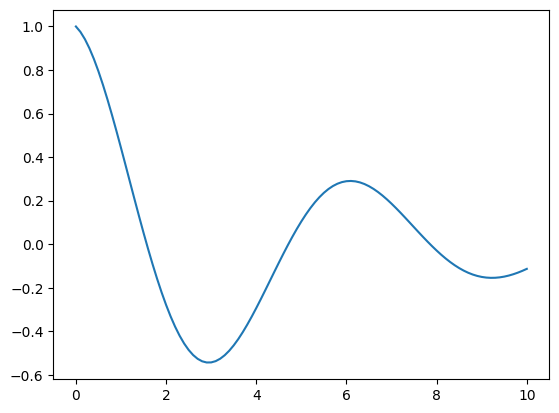

In [ ]:
# x の数列を作成
x = np.arange(0.0,10.01,0.1)
# 対応するyの数列を作成
y = np.exp(-0.2*x) * np.cos(x)
# x と yは同じ長さの数列
print('length of x:',len(x))
print('length of y:',len(y))
plt.plot(x,y)

なお、`plot()`の引数として、数列を1つだけ与えたときには、それはy座標の値の数列として解釈され、x座標は0から始まり1ずつ増える同じ長さの数列によって補完されます。前例のように、x座標の数列が等間隔(横軸の刻み幅が同じ)場合は見た目は変わりません。

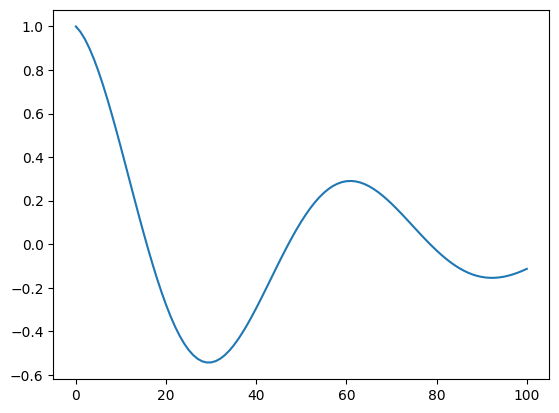

In [ ]:
# y座標の数列だけを与えた場合、x座標は0から1ずつ増える数列で自動補完される
# 上のグラフと見た目は変わらないが、x軸の数値ラベルが異なる
plt.plot(y)

`plot()`で描画される線については、線種、色、太さ、マーカーなどのプロパティーをきめ細かく設定することができます。詳細は[公式ドキュメント](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.plot.html#matplotlib.axes.Axes.plot)等を見てください。

`plot()`の使い方でよくあるのが、x軸の値の数列は共通にして、複数の(折れ)線を同時にプロットすることです。<font color="red">例えば、xが長さ`N`の1次元arrayだとして、m個の線を描画する場合には、N行m列の2次元arrayを第二引数に与えます</font>。

下の例では、$y=e^{-\frac{x}{5}} \cos x$と、$y=e^{-\frac{x}{10}} \cos 3x$を同時にプロットしています。

(101, 2)


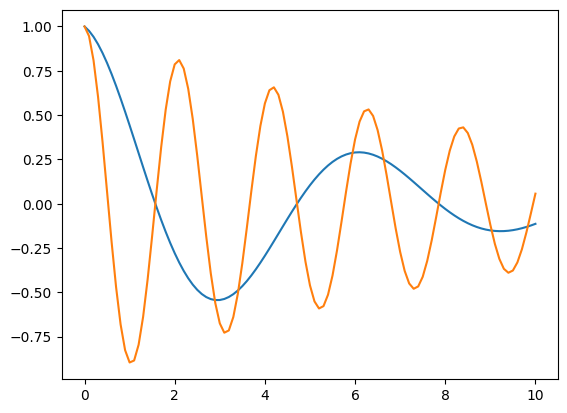

In [ ]:
# 2つ目のyの数値列を作成
y2 = np.exp(-0.1*x) * np.cos(3*x)
# y と y2 を、101行2列の2次元array(行列)にまとめる
Y = np.column_stack((y,y2))
# Yの形を確認。
print(Y.shape)
# プロット
plt.plot(x,Y)

## `scatter(x,y)` : 散布図

yがxの関数という訳ではなくて、点(x,y)の集合を文字通り「点」としてプロットしたい場合、すなわち、散布図を描くときに使うのが、`scatter(x,y)`関数です。（本当は、`plot()`関数で代用することもできますが、散布図に特化した`scatter()`を使う方が楽です。)

次の例では、x座標もy座標も、標準正規分布${\cal N}(0,1)$に従う乱数からサンプリングして1000個の点を得て、散布図を描いています。

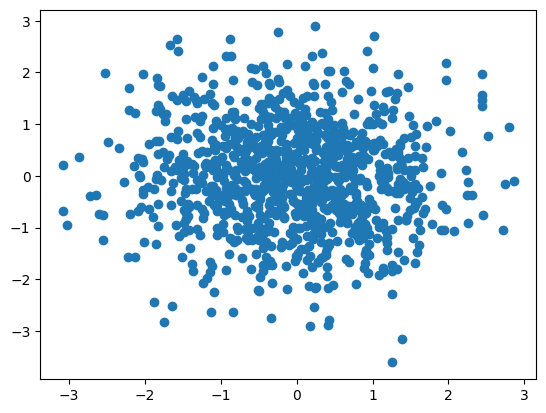

In [ ]:
# 1000行2列の標準正規分布に従う乱数
pts = np.random.randn(1000,2)
# 0列目をx座標、1列目をy座標として散布図をプロット
plt.scatter(pts[:,0],pts[:,1])

ちなみに、複数のグループの点群を点の色を変えて一緒にプロットするのに一番簡単な方法は、それぞれのグループを連続して`scatter()`関数でプロットすることです。これで自動的に各グループの点の色を変えてくれます。
それ以外にも、点群に含まれる各点の色、サイズ、形などを個別に設定する方法もありますが、必要になったときに[公式ドキュメントの説明](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.scatter.html#matplotlib.axes.Axes.scatter)を読んで下さい。

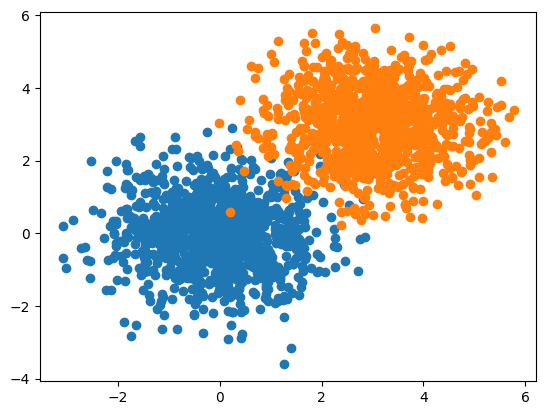

In [ ]:
# 1000行2列の標準正規分布に従う乱数に3を足した数列
pts2 = np.random.randn(1000,2)+3
plt.scatter(pts[:,0],pts[:,1])
plt.scatter(pts2[:,0],pts2[:,1])


## `bar(x,y)`:棒グラフ と`hist(x)`: ヒストグラム

コインを10回投げて表が出る回数を記録するというのを1試行とし、それを1000回繰り返すとします。
これは、numpyのrandomサブモジュールに含まれる`binomial()`関数でシミュレートすることができます。

In [ ]:
# 10回コインを投げて表が出る回数を1000試行分記録する
xarr = np.random.binomial(10,0.5,1000)
# 最初の10試行の結果
print(xarr[:10])

[6 3 7 6 3 4 4 8 3 3]


このとき、$k=0,1,\cdots,10$に対して、表が出た回数が$k$回だった試行数をカウントして集計したいとします。
リストを使って素朴にやるとしたら、こんな感じになると思います。

In [ ]:
# カウンターの全ての値を0に初期化
ct = [0]*11
for x in xarr: # 1つずつ取り出してカウント
  ct[x] += 1
# 結果表示
for k in range(11):
  print(k,':',ct[k])

0 : 0
1 : 8
2 : 31
3 : 116
4 : 206
5 : 230
6 : 239
7 : 104
8 : 47
9 : 17
10 : 2


これを、matplotlibの`bar(x,y)`関数を使って棒グラフとして表示するには、1つめの引数として各棒のx座標の配列（今回の場合、$k=0,1,\cdots,10$）、2つめの引数として各棒の高さ（今回の場合は表が$k$回出た試行回数）を与えます。すなわち、
```
plt.bar(range(11),ct)
```
のようになります。

<BarContainer object of 11 artists>

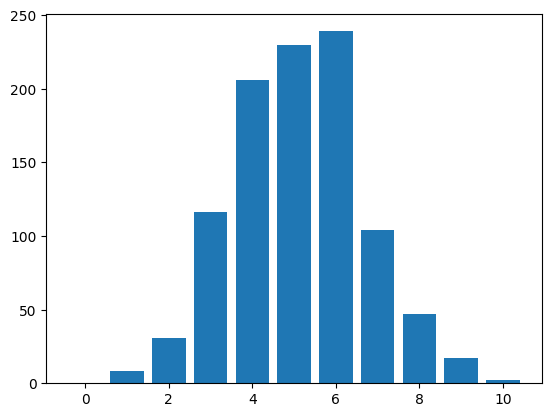

In [ ]:
plt.bar(range(11),ct)

コイン投げのような離散的な確率事象を扱う場合は、このように`bar(x,y)`関数で棒グラフを書いても簡単なのですが、連続的な事象（確率変数が実数値を取る場合）や、離散的事象でも取りうる値が膨大にある場合には、この方法では集計処理が面倒です。

そのような時に便利なのが`hist()`関数です。簡単な例として、標準正規分布からサンプリングした10000個の値のヒストグラムを書いてみると、

(array([  11.,  129.,  659., 1953., 2997., 2690., 1206.,  305.,   44.,
           6.]),
 array([-3.86312014, -3.04898997, -2.2348598 , -1.42072964, -0.60659947,
         0.2075307 ,  1.02166086,  1.83579103,  2.6499212 ,  3.46405136,
         4.27818153]),
 <BarContainer object of 10 artists>)

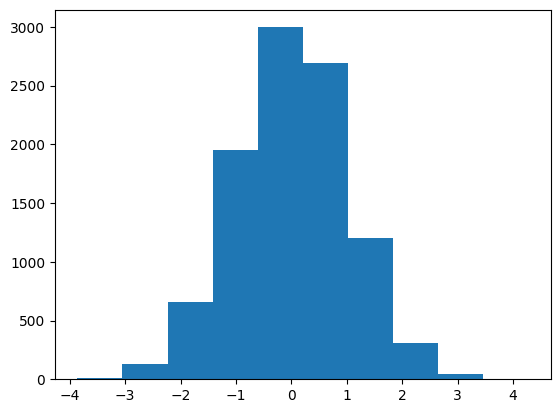

In [ ]:
xarr = np.random.randn(10000)
plt.hist(xarr)

デフォルトだと値の分割が粗い(10分割)ので、分割数を調整するにはオプション引数`bins=`を使います。

(array([  1.,   0.,   1.,   2.,   0.,   1.,   3.,   0.,   0.,   3.,   3.,
          5.,   5.,  10.,   8.,  14.,  20.,  13.,  18.,  33.,  34.,  41.,
         30.,  53.,  62.,  55.,  77.,  81., 101., 125., 101., 152., 157.,
        187., 194., 209., 212., 224., 265., 252., 253., 266., 277., 297.,
        290., 307., 338., 342., 326., 301., 328., 310., 270., 298., 317.,
        228., 258., 247., 216., 218., 197., 164., 153., 145., 106., 130.,
        101.,  86.,  71.,  53.,  56.,  44.,  48.,  38.,  36.,  19.,  17.,
         15.,  26.,   6.,  10.,   6.,   5.,   4.,   3.,   5.,   4.,   2.,
          1.,   4.,   2.,   1.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([-3.86312014, -3.78170712, -3.7002941 , -3.61888109, -3.53746807,
        -3.45605505, -3.37464204, -3.29322902, -3.211816  , -3.13040299,
        -3.04898997, -2.96757695, -2.88616394, -2.80475092, -2.7233379 ,
        -2.64192489, -2.56051187, -2.47909885, -2.39768584, -2.31627282,
        -2.2348598 , -2.15

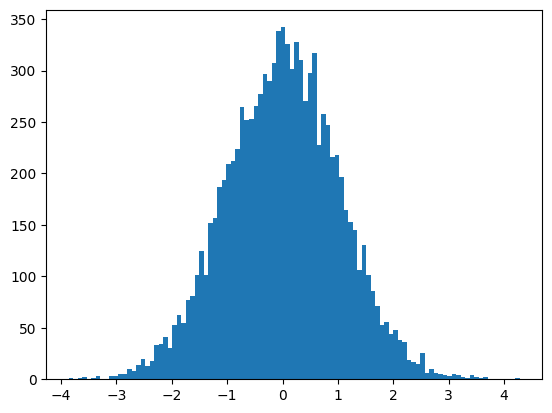

In [ ]:
plt.hist(xarr,bins=100) # 20分割

**(練習)** 確率変数$X$が標準正規分布${\cal N}(0,1)$に従うとき、$X^2$は<font color="red">自由度1のカイ２乗分布</font>に従うことが知られています。その概形を上で生成したサンプルと`hist()`関数を使って描いてみてください。

ちなみに、`hist2d(x,y)`関数は、2次元のデータの頻度分布をカラーマップで可視化してくれます。

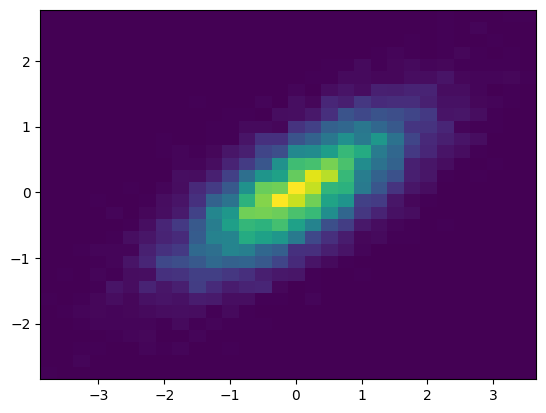

In [ ]:
yarr = (xarr + np.random.randn(10000))/2
res = plt.hist2d(xarr,yarr,bins=30)

---
以下のPandasに関する内容については、[別ノートブック](https://colab.research.google.com/drive/1GLq2NuQ0tWpFEv1f9C4tdbTneesQzRDQ?usp=sharing)に作り直しましたので、そちらを参照してください。
---

## Pandas によるデータ処理

前々回、CSVファイルからデータを読み込む基本的な方法を紹介しましたが、現在、Pythonでデータ処理を行う場合は、Pandasと呼ばれるライブラリを使うのがド定番です。これも非常に高機能なので完全に使いこなすには訓練が必要ですが、一番重要なのは、<font color="blue">データフレーム(data frame)</font>という構造です。データフレームは行と列から成る２次元じょうのテーブルで、例えばExcelシートのようなスプレッドシートをイメージすると良いと思います。

まず、Pandasを使うには、他のモジュール・ライブラリと同様にまずインポートする必要がありますが、
```
import pandas as pd
```
のように、`pandas`(5文字)を`pd`(2文字)に短縮して使うのが慣習となっています。

とりあえず、前々回に使った東京の天気データ(`weather_tokyo_1980_2023.csv`)をPandasのデータフレームに読み込んでみましょう。Pandasには、CSVファイルを読み込むための関数`read_csv()`が用意されています。
<font color="red">Googleドライブをマウントした上で</font>、CSVファイルに含まれているデータをデータフレームに読み込むために、以下のコードを実行します。
```
dfw = pd.read_csv("drive/My Drive/weather_tokyo_1980_2023.csv",index_col=0,parse_dates=True)
```

もっとシンプルに、
```
dfw = pd.read_csv("drive/My Drive/weather_tokyo_1980_2023.csv")
```
でも読み込めるのですが、このデータの場合、先頭列に`1980/6/1`のような年月日が順番に並んでおり、かつ、他の行はその年月日の気象情報が羅列されているので、`index_col=0,parse_dates=True`というオプション引数を与えて、明示的に<font color="blue">先頭行を年月日として扱うようにしています。</font> このようにしてデータを読み込むことのメリットについては後で述べます。


In [ ]:
import pandas as pd
dfw = pd.read_csv("drive/My Drive/weather_tokyo_1980_2023.csv",index_col=0,parse_dates=True)

これで、CSVファイルから全てのデータが、`dfw`という変数名が付けられたデータフレームに読み込まれました。
`print()`関数で中身を見ることができます。行数が非常に多いので、自動的に最初と最後の数行ずつが表示されます。

In [ ]:
print(dfw)

            temp_hi  temp_lo  rain   sun  wind  vapor  cloud
date                                                        
1980-06-01     25.0     18.7   0.0   1.1   1.7   20.1   10.0
1980-06-02     27.3     21.1  13.5   5.4   3.2   21.9   10.0
1980-06-03     28.3     20.4   2.0   5.7   2.4   22.3    9.0
1980-06-04     24.9     20.4   0.0   5.7   3.4   14.6    7.0
1980-06-05     27.2     19.4   0.0  11.0   2.2   16.5    5.3
...             ...      ...   ...   ...   ...    ...    ...
2023-04-03     18.4      9.5   0.0   8.4   2.9    8.3    3.8
2023-04-04     21.0      7.7   0.0  10.5   2.3    8.2    2.5
2023-04-05     21.8      9.8   0.0   6.3   4.0   10.5    8.8
2023-04-06     23.4     16.3   0.0   3.5   6.2   14.5    6.8
2023-04-07     21.3     17.0  11.5   0.2   6.4   18.0    9.0

[15651 rows x 7 columns]


なお、`print()`関数の代わりに、`display()`関数を使うか、あるいは、もっと簡単に
```
dfw
```
のようにデータフレーム名を直接コードセルで実行すると、少しだけ見やすく書式化されて表示されます。

In [ ]:
display(dfw)

,temp_hi,temp_lo,rain,sun,wind,vapor,cloud
date,,,,,,,
1980-06-01,25.0,18.7,0.0,1.1,1.7,20.1,10.0
1980-06-02,27.3,21.1,13.5,5.4,3.2,21.9,10.0
1980-06-03,28.3,20.4,2.0,5.7,2.4,22.3,9.0
1980-06-04,24.9,20.4,0.0,5.7,3.4,14.6,7.0
1980-06-05,27.2,19.4,0.0,11.0,2.2,16.5,5.3
...,...,...,...,...,...,...,...
2023-04-03,18.4,9.5,0.0,8.4,2.9,8.3,3.8
2023-04-04,21.0,7.7,0.0,10.5,2.3,8.2,2.5
2023-04-05,21.8,9.8,0.0,6.3,4.0,10.5,8.8


いずれにせよ、このデータがテーブル状（スプレッドシート状）になっていて、きちんとヘッダー行、日時列が認識されていることが分かります。

ちなみに、データフレームの`head()`メソッド、`tail()`メソッドを使って、「最初のn行を表示する」「最後のn行を表示する」というようなことも簡単にできます。

In [ ]:
dfw.tail(10)

,temp_hi,temp_lo,rain,sun,wind,vapor,cloud
date,,,,,,,
2023-03-29,18.6,8.3,15.5,3.7,2.2,10.4,6.0
2023-03-30,19.7,10.1,0.5,5.8,2.4,11.9,6.5
2023-03-31,20.1,10.4,0.0,4.6,2.6,12.2,6.3
2023-04-01,23.3,10.3,0.0,10.6,2.6,11.2,2.3
2023-04-02,19.0,11.1,0.0,2.0,3.2,10.7,9.8
2023-04-03,18.4,9.5,0.0,8.4,2.9,8.3,3.8
2023-04-04,21.0,7.7,0.0,10.5,2.3,8.2,2.5
2023-04-05,21.8,9.8,0.0,6.3,4.0,10.5,8.8
2023-04-06,23.4,16.3,0.0,3.5,6.2,14.5,6.8


また、データフレームの`describe()`メソッドを使うと、各列についての基本統計値(要素数, 平均, 標準偏差, 最小値, 最大値, 25,50,75各パーセンタイル点)を表示してくれるので、ざっくりとどんなデータなのかを見るのに便利です。

In [ ]:
dfw.describe()

,temp_hi,temp_lo,rain,sun,wind,vapor,cloud
count,15651.000000,15650.000000,15651.000000,15651.000000,15628.000000,15651.000000,15651.000000
mean,20.229544,12.965936,4.289981,5.322069,3.196129,13.703150,6.554942
std,7.958852,8.102258,13.152824,4.030873,1.064400,8.190132,3.310700
min,0.700000,-4.000000,0.000000,0.000000,0.800000,1.700000,0.000000
25%,13.200000,5.400000,0.000000,0.900000,2.400000,6.300000,4.000000
50%,20.500000,13.200000,0.000000,5.700000,3.000000,12.100000,7.500000
75%,26.500000,19.800000,1.500000,8.900000,3.700000,20.300000,9.800000
max,39.500000,30.400000,259.500000,13.800000,9.100000,34.500000,10.000000


### データフレームの列と行(インデクス)

まず、このテーブル状のデータフレームの「列名のリスト」は、`columns`属性として参照することができます。
```
dfw.columns
```

In [ ]:
# 列名のリスト
dfw.columns

Index(['temp_hi', 'temp_lo', 'rain', 'sun', 'wind', 'vapor', 'cloud'], dtype='object')

そして、このデータフレームから、特定の列だけを取り出したいときには、列名をインデクスとして使うことができます。具体的には、
`データフレーム名['列名']` のような形式になります。例えば、`dfw`から雨量の列だけを取り出す場合は以下のようになります。

In [ ]:
# 雨量('rain')の列だけを取り出す
dfw['rain']

date
1980-06-01     0.0
1980-06-02    13.5
1980-06-03     2.0
1980-06-04     0.0
1980-06-05     0.0
              ... 
2023-04-03     0.0
2023-04-04     0.0
2023-04-05     0.0
2023-04-06     0.0
2023-04-07    11.5
Name: rain, Length: 15651, dtype: float64

なお、複数の列を取り出す場合は、`データフレーム名[['列名1','列名2',...,'列名n']]`のように、取り出したい列の名前をリストにします。

**(練習)** データフレーム`dfw`から、最高気温と最低気温の列だけを取り出してください。

次に、行名(インデクス名)の一覧は、データフレームの`index`属性で参照することができます。今回のデータの場合、年月日の一覧になります。

In [ ]:
# インデクス=日付 の一覧
print(dfw.index)

DatetimeIndex(['1980-06-01', '1980-06-02', '1980-06-03', '1980-06-04',
               '1980-06-05', '1980-06-06', '1980-06-07', '1980-06-08',
               '1980-06-09', '1980-06-10',
               ...
               '2023-03-29', '2023-03-30', '2023-03-31', '2023-04-01',
               '2023-04-02', '2023-04-03', '2023-04-04', '2023-04-05',
               '2023-04-06', '2023-04-07'],
              dtype='datetime64[ns]', name='date', length=15651, freq=None)


あるインデクス(このデータの場合は年月日)のデータを取り出したい場合は、データフレームの`loc`属性を使って、そのインデクスを指定します。

例えば、2015年4月25日の天気データは、
```
dfw.loc['2015-04-25']
```
で参照することができます。

**(練習)** 自分が生まれた日の天気データを取り出して表示してみてください。

ここで、日付(年月日)をインデクスとしてデータを読み込んだことのメリットについて少し見てみます。

まず、ある日から連続する数日間のデータを取り出したい場合、<font color="blue">日時についてのスライスを使うことができます。</font>
例えば、昨年の4月1日からの1週間の天気情報は、
```
dfw.loc['2022-04-01':'2022-04-07']
```
で参照することができます。

In [ ]:
dfw.loc['2022-04-01':'2022-04-07']

,temp_hi,temp_lo,rain,sun,wind,vapor,cloud
date,,,,,,,
2022-04-01,12.4,3.9,16.5,5.2,3.2,6.3,9.8
2022-04-02,12.9,3.6,0.0,11.6,3.0,5.7,7.8
2022-04-03,10.1,6.6,13.5,0.0,2.6,9.2,10.0
2022-04-04,9.8,6.7,53.5,0.0,3.4,10.7,10.0
2022-04-05,17.9,8.2,1.5,3.1,2.8,11.4,9.5
2022-04-06,21.8,10.6,0.0,7.9,2.1,12.4,9.0
2022-04-07,19.2,10.9,0.0,6.2,2.9,11.6,7.8


また、ある月の最初の日から最後の日までのデータは、`データフレーム.iloc['YYYY-MM']` の形式で取り出すことができます。例えば、2022年の5月のデータは、
```
dfw.loc['2022-05']
```
でまるごと参照することができます。これと、後で出てくる`mean()`メソッドなどを組み合わせれば、月ごとの平均気温を簡単に求めることができます。


In [ ]:
# まず、2022年5月の1ヶ月分のデータをそのまま表示
display(dfw.loc['2022-05'])
# その月の各列の平均を表示
dfw.loc['2022-05'].mean()

,temp_hi,temp_lo,rain,sun,wind,vapor,cloud
date,,,,,,,
2022-05-01,16.8,10.8,12.0,0.0,2.1,12.0,9.8
2022-05-02,19.4,9.5,1.0,4.1,2.7,11.0,8.5
2022-05-03,20.4,9.3,0.0,12.3,2.7,10.4,0.8
2022-05-04,25.0,10.8,0.0,12.4,2.9,11.8,2.5
2022-05-05,26.3,13.6,0.0,11.8,2.7,14.6,6.5
2022-05-06,24.5,15.2,0.0,7.9,3.1,15.9,10.0
2022-05-07,22.8,15.4,7.5,0.8,1.8,18.5,8.8
2022-05-08,22.5,16.2,0.0,5.1,3.1,12.0,8.0
2022-05-09,17.3,11.2,8.0,0.0,2.4,12.7,10.0


temp_hi    23.506452
temp_lo    14.825806
rain        6.387097
sun         5.841935
wind        2.703226
vapor      16.067742
cloud       7.977419
dtype: float64

**(練習)**昨年の各月ごとの最高気温を求めてみてください。(`max()`メソッドを使うと最大値を求めることができます。)

### 特定の条件を満たすデータを抽出する

データフレームに含まれる列について論理式を適用すると、その列に含まれる全ての値についてその論理式が評価され、`True`または`False`の真偽値がPandasのSeries型というリストに似た形式で得られます。

例えば、
```
dfw['temp_hi']>=35.0
```
とすると、各年月日の最高気温が35度以上かどうかを`True`か`False`のSeries型で返します。

In [ ]:
dfw['temp_hi']>=35.0

date
1980-06-01    False
1980-06-02    False
1980-06-03    False
1980-06-04    False
1980-06-05    False
              ...  
2023-04-03    False
2023-04-04    False
2023-04-05    False
2023-04-06    False
2023-04-07    False
Name: temp_hi, Length: 15651, dtype: bool

ここで注目したいのは、単に`True`か`False`かだけでなく、インデクスである年月日の情報もきちんと残っている点です。これを活用すると、データフレームの中の<font color="blue"> 特定の条件を満たす行を抽出する </font>ことが容易に実現できます。

例えば、過去43年間で、最高気温が38度以上だった日の天気データを抽出したかったら、
```
flg = dfw['temp_hi'] >= 38.0
display(dfw.loc[flg])
```
とすれば良いです。ここでは、見やすさのために一時変数`flg`を使いましたが、一行で、
```
dfw.loc[dfw['temp_hi'] >= 38.0]
```
としても同じ結果が得られます。

In [ ]:
flg = dfw['temp_hi'] >= 38.0
display(dfw.loc[flg])

,temp_hi,temp_lo,rain,sun,wind,vapor,cloud
date,,,,,,,
1984-09-03,38.1,24.7,0.0,11.3,3.7,27.4,2.8
1994-08-03,39.1,27.7,0.0,8.5,2.9,26.2,8.0
1996-08-15,38.7,27.0,0.0,6.6,5.7,27.4,7.0
2001-07-24,38.1,28.2,0.0,8.9,2.4,28.7,2.3
2004-07-20,39.5,27.3,0.0,11.2,3.5,21.2,5.5
2004-07-21,38.1,29.6,0.0,9.0,3.6,21.6,4.0
2013-08-11,38.3,30.4,0.0,8.0,2.2,30.5,6.5
2018-07-23,39.0,28.5,0.0,10.0,2.9,28.0,7.5


**(練習)** 1日の寒暖差が17度以上あった日のデータを抽出してください。

**(練習)** 1日の降雨量が100mm以上で、かつ、日照時間が1時間以上あった日を調べてください。

ある列の最大値や最小値、平均値は、それぞれ、`max()`,`min()`,`mean()`メソッドを使えば簡単に求まりますが、「最大値を取る日」あるいは「最小値を取る日」の行を求めるには、少々工夫が必要です。

まず、素朴な方法は、最大値・最小値を求めてから、その値を取る日を抽出することです。例えば、43年間で一番日照時間が長かった日は、次のようにして求めることができます。

In [ ]:
# 最大の日照時間
mxsun = dfw['sun'].max()
print(mxsun)
# 日照時間がそれと等しい日のデータを表示
dfw.loc[dfw['sun']==mxsun]

13.8


,temp_hi,temp_lo,rain,sun,wind,vapor,cloud
date,,,,,,,
2007-05-20,25.0,14.6,0.0,13.8,4.4,8.6,0.8


ただ、この方法は、まず全データを走査して最大値を求めてから、再び走査してその値と等しい行を見つけているので、効率が悪いように思えます。

別の方法としては、`idxmax()`,`idxmin()`メソッドを使って、最大値または最小値を取る行のインデクスを求めることが考えられます。

In [ ]:
dfw.loc[[(dfw['sun']).idxmax()]]

,temp_hi,temp_lo,rain,sun,wind,vapor,cloud
date,,,,,,,
2007-05-20,25.0,14.6,0.0,13.8,4.4,8.6,0.8


**(練習)** 寒暖差が最も大きかった日、最も小さかった日を調べてください。

### 週・月・年平均を求めてグラフを描く

`resample()`メソッドを使うと、すごく簡単に書けるのですが、説明するのが難しいです。。
以下の例は、最高気温、最低気温の年平均（ただし、1980年と2023年は不完全なので除外）を求めてプロットするものです。

なお、Pandasでは、前述のMatplotlibの主要なプロット関数をラッピングしているので、
```
plt.plot(dfw['temp_hi'].resample('Y').mean().iloc[1:-1])
```
は、
```
dfw['temp_hi'].resample('Y').mean().iloc[1:-1].plot()
```
としても同じ結果が得られます。


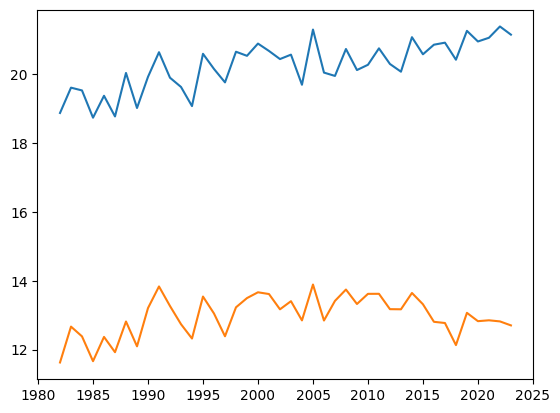

In [ ]:
plt.plot(dfw['temp_hi'].resample('Y').mean().iloc[1:-1])
plt.plot(dfw['temp_lo'].resample('Y').mean().iloc[1:-1])


**(練習)** 1981年から2022年までの年ごとの合計降水量を求めてプロットしてみてください。

# 今日の課題 (HW2023-01)

前回出題予定だった課題です。詳細は[課題ファイル自体](https://colab.research.google.com/drive/16_GIT47-AErzOPLa76H-5M9-FshpE5gU?usp=share_link)を参照してください。

締切りは、<font color='red'>5月9日8時30分 (次々回授業の直前) </font>までとします。
